# Predicting GroundState Energy from Coulomb Matrices

This [dataset](https://www.kaggle.com/datasets/burakhmmtgl/energy-molecule) contains ground state energies of 16,242 molecules calculated by quantum mechanical simulations.

The data contains 1277 columns. The first 1275 columns are entries in the Coulomb matrix that act as molecular features. The 1276th column is the Pubchem Id where the molecular structures are obtained. The 1277th column is the atomization energy calculated by simulations using the Quantum Espresso package.

In the csv file, the first column (X1) is the data index.

The dataset was used for a [publication using a tree based ML Framework](https://arxiv.org/pdf/1609.07124.pdf).

## Getting the data

We create a class that inherits from torch's `Dataset` class to create our own dataset object. It must include the three given methods.

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np

In [2]:
class GS_from_CM_Dataset(Dataset):
    
    def __init__(self, path_to_data, transform=None):
        
        self.path_to_data = path_to_data
        if os.path.exists(path_to_data):
            self.data = pd.read_csv(path_to_data)
        else:
            raise FileExistsError('No dataset found')
        self.transform = transform

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        energy = self.data.iloc[idx, -1]
        CMat = self.data.iloc[idx, 1:-2]

        return torch.tensor(CMat).to(torch.float), torch.tensor(energy).to(torch.float)

In [3]:
# Using dataloader
dataset = GS_from_CM_Dataset(path_to_data='data/GS_from_CM/GS_from_CM_data.csv')

# Just checking that everything works fine
print(len(dataset))
for i in range(5):
    sample_X, sample_y = dataset[i]
    print(i, sample_X.shape, sample_y)

16242
0 torch.Size([1275]) tensor(-19.0138)
1 torch.Size([1275]) tensor(-10.1610)
2 torch.Size([1275]) tensor(-9.3766)
3 torch.Size([1275]) tensor(-13.7764)
4 torch.Size([1275]) tensor(-8.5371)


Now we can use the DataLoader function to use the dataset in PyTorch

In [4]:
N_all = len(dataset)

# input_len = dataset[0]['CMat'].shape[0]
input_len = dataset[0][0].shape[0]
batch_size = 32

subset = 1

used_data, _ = torch.utils.data.random_split(dataset, (int(N_all*subset), N_all - int(N_all*subset)))

N = len(used_data)
print(f'Using a subset of {N} data out of {N_all}')

train_data, test_data = torch.utils.data.random_split(used_data, (int(N*0.9), N - int(N*0.9)))

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data)

Using a subset of 16242 data out of 16242


Now we can start to build our NN.

In [5]:
from torch import nn

class SimpleNN(nn.Module):
    
    def __init__(self):
        super(SimpleNN, self).__init__()
        # The input is a 1275 vector
        self.linear_relu_block = nn.Sequential(
            nn.Linear(input_len, 16, bias=False),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
            )
    
    def forward(self, x):
        logits = self.linear_relu_block(x)
        return logits.squeeze()
    
    
model = SimpleNN()
model.eval()  # Congelas gradients

# Check if it works
random_result = model(torch.rand(input_len))
print(random_result.shape)

torch.Size([])


Now we can train the model. We use the SGD method, since I don't know how the rest work (TODO: Learn the others).

In [6]:
# import time
learning_rate = 1e-3
epochs = 5

SGD_opt = torch.optim.SGD(model.parameters(), lr=learning_rate)
MSE_fn = nn.MSELoss()

def train_epoch(train_data, model, optimizer, loss_fn):
    for batch, (X, y) in enumerate(train_data):
        # print(X.shape)
        # print(y.shape)
        # Prediction and loss
        # start = time.perf_counter()
        model.train()
        y_pred = model(X)
        loss = loss_fn(y_pred, y.squeeze())
        
        # Calculate gradient and modify parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # end = time.perf_counter()
        # timer = end-start
        # print(timer)
        
        if (batch+1) % (len(train_data) // 10) == 0:
            print(f'Current {batch * batch_size:6d} / {N:6d}. Train MSE = {loss:4.4f}', end='\r')
    return loss.item()

def test_epoch(test_data, model, loss_fn):
    # N = len(test_data.dataset)
    N = len(test_data.dataset)
    Mse = 0
    for X, y in test_data:
    
        # with torch.no_grad():
        model.eval()
        # for X, y in test_data:
        y_pred = model(X)
        Mse += loss_fn(y_pred, y.squeeze()).item()
    print(f'\nTest MSE {Mse / N:4.4f}')
    return Mse / N

def train_loop(train_data, test_data, model, optimizer, loss_fn, epochs=1):
    train_mse = []
    test_mse = []
    for epoch in range(epochs):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        print('-'*50)
        
        tr_mse = train_epoch(train_data, model, optimizer, loss_fn)
        te_mse = test_epoch(test_data, model, loss_fn)
        
        train_mse.append(tr_mse)
        test_mse.append(te_mse)
    return [np.array(l) for l in (train_mse, test_mse)]

We have defined the model and its training loop. Let's put it to use

In [7]:
from time import perf_counter

start = perf_counter()
train_mse, test_mse = train_loop(train_dataloader, test_dataloader, model, SGD_opt, MSE_fn, epochs=epochs)
end = perf_counter()

print(f'\nRun time for {epochs} epochs was {end - start:>4f} seconds.')


Epoch 1/5
--------------------------------------------------
Current  14368 /  16242. Train MSE = 19.0256
Test MSE 12.4748

Epoch 2/5
--------------------------------------------------
Current  14368 /  16242. Train MSE = 11.4321
Test MSE 12.4511

Epoch 3/5
--------------------------------------------------
Current  14368 /  16242. Train MSE = 15.0863
Test MSE 12.4856

Epoch 4/5
--------------------------------------------------
Current  14368 /  16242. Train MSE = 24.4271
Test MSE 12.4290

Epoch 5/5
--------------------------------------------------
Current  14368 /  16242. Train MSE = 11.4180
Test MSE 12.4321

Run time for 5 epochs was 235.917386 seconds.


The model is much slower than not using DataLoader.

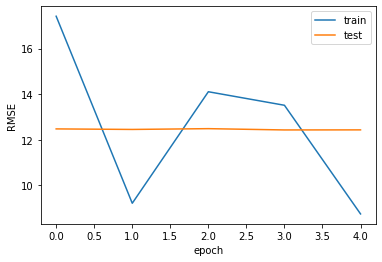

In [8]:
import matplotlib.pyplot as plt

plt.plot(train_mse, label='train')
plt.plot(test_mse, label='test')
plt.legend()
# plt.yscale('log')
plt.xlabel('epoch')
plt.ylabel('RMSE')

plt.show()